Lista 3 - Lab3 - Laurindo dos Santos - 131710114 - UFABC - Mestrado em Engenharia da Informação - Correções

In [2]:
from pyspark import SparkContext

In [3]:
sc = SparkContext()

In [6]:
import os
import numpy as np

filename = "c:\\Data\\Aula03\\Crime.csv"
CrimeRDD = sc.textFile(filename,8)
header = CrimeRDD.take(1)[0] # o cabeçalho é a primeira linha do arquivo

print ("Campos disponíveis: {}".format(header))

Campos disponíveis: Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y


In [8]:
# EXERCICIO
CrimeHeadlessRDD = (CrimeRDD.filter(lambda x: x != header))

firstObject = CrimeHeadlessRDD.take(1)[0]
print (firstObject)

2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747


In [9]:
assert firstObject=='2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747', 'valor incorreto'
print ("OK")

OK


In [10]:
# EXERCICIO
CrimeHeadlessRDD = (CrimeRDD
                        .filter(lambda x: x != header)
                        .map(lambda x: x.split(","))
                        .collect()
                    )

firstObjectList = CrimeHeadlessRDD[0]

print (firstObjectList)

['2015-05-13 23:53:00', 'WARRANTS', 'WARRANT ARREST', 'Wednesday', 'NORTHERN', '"ARREST', ' BOOKED"', 'OAK ST / LAGUNA ST', '-122.425891675136', '37.7745985956747']


In [11]:
assert firstObjectList[0]=='2015-05-13 23:53:00', 'valores incorretos'
print ("OK")

OK


In [13]:
# EXERCICIO

import re
import datetime
from collections import namedtuple

headeritems = header.split(',') # transformar o cabeçalho em lista
del headeritems[-1] # apagar o último item e...
headeritems[-1] = 'COORD' # transformar em COORD

# Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,COORD
Crime = namedtuple('Crime',headeritems) # gera a namedtuple Crime com os campos de header

REGEX = r',(?=(?:[^"]*"[^"]*")*(?![^"]*"))'
# buscar por "," tal que após essa vírgula (?=) ou exista um par de "" ou não tenha " sozinha
# ?= indica para procurarmos pelo padrão após a vírgula
# ?: significa para não interpretar os parênteses como captura de valores
# [^"]* 0 ou sequências de caracteres que não sejam aspas
# [^"]*"[^"]*"  <qualquer caracter exceto aspas> " <qualquer caracter exceto aspas> "
# ?! indica para verificar se não existe tal padrão a frente da vírgula

def ParseCrime(rec):
    # utilizando re.split() vamos capturar nossos valores
    
    #for line in rec:
    Dates, Category, Descript, DayOfWeek, PdDistrict, Resolution, Address, X, Y = re.split(REGEX, rec.strip())
    
    #Date, Category, Descript, DayOfWeek, PdDistrict, Resolution, Address, X, Y = rec.foreach(lambda x: re.split(REGEX, x))    
    
    # Converta a data para o formato datetime
    Dates = datetime.datetime.strptime(Dates, "%Y-%m-%d %H:%M:%S")

    # COORD é uma tupla com floats representando X e Y
    COORD = (float(X), float(Y))

    # O campos 'Resolution' será uma lista dos valores separados por vírgula, sem as aspas
    Resolution = Resolution.strip('",').split()

    return Crime(Dates, Category, Descript, DayOfWeek, PdDistrict, Resolution, Address, COORD)


# Aplique a função ParseCrime para cada objeto da base
CrimeHeadlessRDD = sc.parallelize(CrimeRDD
                                    .filter(lambda x: x != header)
                                    .map(lambda x: ParseCrime(x))
                                    .collect()
                                 )



firstClean = CrimeHeadlessRDD.first()
totalRecs = CrimeHeadlessRDD.count()
print (firstClean)

Crime(Dates=datetime.datetime(2015, 5, 13, 23, 53), Category='WARRANTS', Descript='WARRANT ARREST', DayOfWeek='Wednesday', PdDistrict='NORTHERN', Resolution=['ARREST,', 'BOOKED'], Address='OAK ST / LAGUNA ST', COORD=(-122.425891675136, 37.7745985956747))


In [14]:
assert type(firstClean.Dates) is datetime.datetime and type(firstClean.Resolution) is list and type(firstClean.COORD) is tuple,'tipos incorretos'
print ("OK")

assert CrimeHeadlessRDD.filter(lambda x: len(x)!=8).count()==0, 'algo deu errado!'
print ("OK")

assert totalRecs==878049, 'total de registros incorreto'
print ("OK")

OK
OK
OK


In [15]:
# EXERCICIO

CatCountRDD = sc.parallelize(CrimeHeadlessRDD
                                 .map(lambda x: (x.Category, 1))
                                 .groupByKey()
                                 .mapValues(sum)
                                 .collect()
                            )

catCount = sorted(CatCountRDD.collect(), key=lambda x: -x[1])

print (catCount)

[('LARCENY/THEFT', 174900), ('OTHER OFFENSES', 126182), ('NON-CRIMINAL', 92304), ('ASSAULT', 76876), ('DRUG/NARCOTIC', 53971), ('VEHICLE THEFT', 53781), ('VANDALISM', 44725), ('WARRANTS', 42214), ('BURGLARY', 36755), ('SUSPICIOUS OCC', 31414), ('MISSING PERSON', 25989), ('ROBBERY', 23000), ('FRAUD', 16679), ('FORGERY/COUNTERFEITING', 10609), ('SECONDARY CODES', 9985), ('WEAPON LAWS', 8555), ('PROSTITUTION', 7484), ('TRESPASS', 7326), ('STOLEN PROPERTY', 4540), ('SEX OFFENSES FORCIBLE', 4388), ('DISORDERLY CONDUCT', 4320), ('DRUNKENNESS', 4280), ('RECOVERED VEHICLE', 3138), ('KIDNAPPING', 2341), ('DRIVING UNDER THE INFLUENCE', 2268), ('RUNAWAY', 1946), ('LIQUOR LAWS', 1903), ('ARSON', 1513), ('LOITERING', 1225), ('EMBEZZLEMENT', 1166), ('SUICIDE', 508), ('FAMILY OFFENSES', 491), ('BAD CHECKS', 406), ('BRIBERY', 289), ('EXTORTION', 256), ('SEX OFFENSES NON FORCIBLE', 148), ('GAMBLING', 146), ('PORNOGRAPHY/OBSCENE MAT', 22), ('TREA', 6)]


In [16]:
assert catCount[0][1]==174900, 'valores incorretos'
print ("OK")

OK


In [17]:
# EXERCICIO

RegionCountRDD = sc.parallelize(CrimeHeadlessRDD
                                  .map(lambda x: (x.PdDistrict, 1))
                                  .groupByKey()
                                  .mapValues(sum)
                                  .collect()
                               )

regCount = sorted(RegionCountRDD.collect(), key=lambda x: -x[1])

print (regCount)

[('SOUTHERN', 157182), ('MISSION', 119908), ('NORTHERN', 105296), ('BAYVIEW', 89431), ('CENTRAL', 85460), ('TENDERLOIN', 81809), ('INGLESIDE', 78845), ('TARAVAL', 65596), ('PARK', 49313), ('RICHMOND', 45209)]


In [18]:
assert regCount[0][1]==157182, 'valores incorretos'
print ("OK")

OK


In [19]:
# EXERCICIO

from operator import add

# Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,COORD

# Lambda para converter um datetime em `Dia-Mes-Ano`
day2str = lambda x: '{}-{}-{}'.format(x.day,x.month,x.year)

totalDatesRDD = sc.parallelize(CrimeHeadlessRDD
                                  .map(lambda x: (x.DayOfWeek, day2str(x.Dates),  1))
                                  .distinct()
                                  .map(lambda x: (x[0], x[2]))
                                  .groupByKey()
                                  .mapValues(sum)
                                  .collect()
                               )

crimesWeekDayRegionRDD = sc.parallelize(CrimeHeadlessRDD
                                           .map(lambda x: ((x.DayOfWeek, x.PdDistrict), 1))
                                           .groupByKey()
                                           .mapValues(sum)
                                           .map(lambda x: (x[0][0], (x[0][1], x[1])))
                                           .collect()
                                       )

RegionAvgPerDayRDD = sc.parallelize(totalDatesRDD
                                         .join(crimesWeekDayRegionRDD)
                                         .map(lambda x: (x[0], (x[1][1][0], float(x[1][1][1]) / float(x[1][0]))))
                                         .groupByKey()
                                         .mapValues(list)
                                         .collect()
                                   )

RegionAvg = RegionAvgPerDayRDD.collectAsMap()
print (RegionAvg['Sunday'])

[('SOUTHERN', 64.82866043613707), ('BAYVIEW', 37.27414330218068), ('PARK', 20.70404984423676), ('MISSION', 49.45171339563863), ('CENTRAL', 37.99688473520249), ('INGLESIDE', 32.230529595015575), ('TENDERLOIN', 31.707165109034268), ('TARAVAL', 25.953271028037385), ('RICHMOND', 18.968847352024923), ('NORTHERN', 44.45794392523364)]


In [20]:

RegionAvgPerDayRDD = sc.parallelize(totalDatesRDD
                                         .join(crimesWeekDayRegionRDD)
                                         .map(lambda x: ((x[0], x[1][1][0]), float(x[1][1][1]) / float(x[1][0])))
                                         .groupByKey()
                                         .mapValues(list)
                                         .collect()
                                   )

RegionAvg = RegionAvgPerDayRDD.collectAsMap()

In [21]:
assert np.round(RegionAvg['Sunday', 'BAYVIEW'],2)==37.27, 'valores incorretos {}'.format(np.round(RegionAvg[0][2],2))
print ("OK")

OK


In [22]:
# EXERCICIO

countWeekDayDistRDD = sc.parallelize(totalDatesRDD
                                         .join(crimesWeekDayRegionRDD)
                                         .map(lambda x: ((x[0], (x[1][1][0])), float(x[1][1][1]) / float(x[1][0])))
                                         .groupByKey()
                                         .mapValues(sum)
                                         .collect()
                                   )

# Esse procedimento só é viável se existirem poucas chaves
RegionAvgSpark = {}
Keys = countWeekDayDistRDD.map(lambda rec: rec[0]).collect()

for key in Keys:

    listRDD = (countWeekDayDistRDD.filter(lambda rec: rec[0][0]==key[0]).map(lambda rec: float(rec[1])))

    if key[0] not in RegionAvgSpark:
        RegionAvgSpark[key[0]] = {}    
    RegionAvgSpark[key[0], key[1]] = (listRDD.mean(), listRDD.stdev())
    
print (RegionAvgSpark['Sunday'])

{}


In [23]:
assert np.round(RegionAvgSpark['Sunday', 'BAYVIEW'][0],2)==36.36 and np.round(RegionAvgSpark['Sunday', 'BAYVIEW'][1],2)==13.21, 'valores incorretos'
print ("OK")

OK


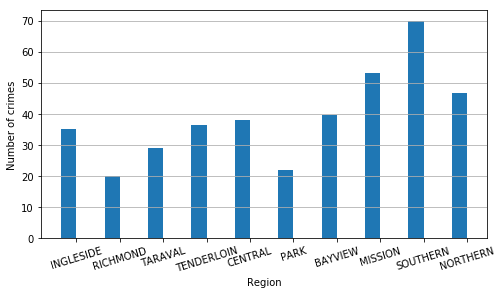

In [24]:
import matplotlib.pyplot as plt

# Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,COORD

# Lambda para converter um datetime em `Dia-Mes-Ano`
day2str = lambda x: '{}-{}-{}'.format(x.day,x.month,x.year)

totalDatesRDD = (CrimeHeadlessRDD
                    .map(lambda rec: (day2str(rec.Dates),1))
                    .reduceByKey(lambda x,y: x)
                 )

totalDays = float(totalDatesRDD.count())

avgCrimesRegionRDD = (RegionCountRDD
                         .map(lambda rec: (rec[0],rec[1]/totalDays))
                     )

Xticks,Y = zip(*avgCrimesRegionRDD.collectAsMap().items())
indices = np.arange(len(Xticks))
width = 0.35

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.bar(indices,Y, width)
plt.grid(b=True, which='major', axis='y')
plt.xticks(indices+width/2., Xticks, rotation=17 )
plt.ylabel('Number of crimes')
plt.xlabel('Region')
plt.show()
pass

(7, 10)


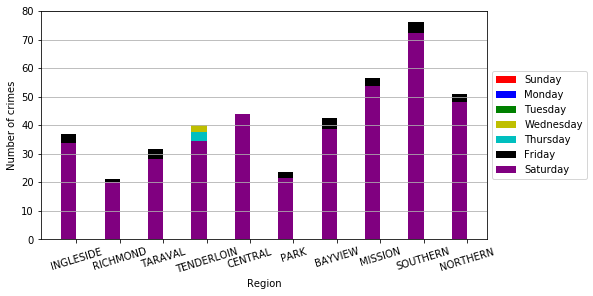

In [38]:
# Dias da semana como referência
Day = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

# Uma cor para cada dia
Color = ['r','b','g','y','c','k','purple']

# Dicionário (dia, array de médias)
Y = {}
for day in Day:
    Y[day] = np.array([RegionAvg[day, x] for x in Xticks])

# Matriz dias x regiões    

Bottom = np.zeros((len(Day), len(Xticks)))

print(Bottom.shape)

#Bottom[0,:] = np.broadcast_to([ 32.2305296   32.2305296   32.2305296   32.2305296   32.2305296   32.2305296   32.2305296   32.2305296   32.2305296   32.2305296 ])

#for i in range (1,len(Day)):
    
#    Bottom[i,:] = Bottom[i-1,:]+Y[Day[i-1]]
    
indices = np.arange(len(Xticks))
width = 0.35

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')

# Gera uma lista de plots, um para cada dia
plots = [plt.bar(indices,Y[Day[i]], width, color=Color[i], bottom=Bottom[i]) for i in range(len(Day))]

plt.legend( [p[0] for p in plots], Day,loc='center left', bbox_to_anchor=(1, 0.5) ) 
    
plt.grid(b=True, which='major', axis='y')
plt.xticks(indices+width/2., Xticks, rotation=17 )
plt.ylabel('Number of crimes')
plt.xlabel('Region')
plt.show()

In [30]:
CrimeHeadlessRDD.take(1)

[Crime(Dates=datetime.datetime(2015, 5, 13, 23, 53), Category='WARRANTS', Descript='WARRANT ARREST', DayOfWeek='Wednesday', PdDistrict='NORTHERN', Resolution=['ARREST,', 'BOOKED'], Address='OAK ST / LAGUNA ST', COORD=(-122.425891675136, 37.7745985956747))]

In [32]:
# EXERCICIO

parseWeekday = lambda x: '{}-{}-{}'.format(x.day, x.month, x.year)

hoursRDD = (CrimeHeadlessRDD
            .map(lambda x: ((parseWeekday(x.Dates),x.Dates.hour),1))
            .reduceByKey(lambda x,y: x)
            .map(lambda x: (x[0][1],1))
            .reduceByKey(lambda x, y: x+y)
           )

crimePerHourRDD = (CrimeHeadlessRDD
                   .map(lambda x: (x.Dates.hour,1))
                   .reduceByKey(lambda x, y: x+y)
                  )

avgCrimeHourRDD = (crimePerHourRDD
                   .join(hoursRDD)
                   .map(lambda x: (x[0], x[1][0]/float(x[1][1])))
                  )

crimePerHour = avgCrimeHourRDD.collect()
print (crimePerHour[0:5])

[(20, 19.881672597864767), (16, 22.302935943060497), (12, 23.102313167259787), (8, 14.62872387727879), (4, 4.570435588507878)]


In [34]:
assert np.round(crimePerHour[0][1],2)==19.88, 'valores incorretos'
print ("OK")

OK


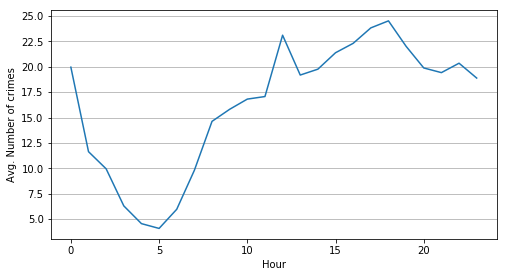

In [37]:
crimePerHourSort = sorted(crimePerHour,key=lambda x: x[0])

X,Y = zip(*crimePerHourSort)

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.plot(X,Y)
plt.grid(b=True, which='major', axis='y')
plt.ylabel('Avg. Number of crimes')
plt.xlabel('Hour')
plt.show()

In [47]:

parseMonthYear = lambda x: '{}-{}'.format(x.month, x.year)

crimes = map(lambda x: x[0], catCount)

CrimeHeadlessRDD.take(1)

[Crime(Dates=datetime.datetime(2015, 5, 13, 23, 53), Category='WARRANTS', Descript='WARRANT ARREST', DayOfWeek='Wednesday', PdDistrict='NORTHERN', Resolution=['ARREST,', 'BOOKED'], Address='OAK ST / LAGUNA ST', COORD=(-122.425891675136, 37.7745985956747))]

In [97]:
CrimeHeadlessRDD.map(lambda x: ((parseMonthYear(x.Dates),x.Category),1)).reduceByKey(lambda x, y: x+y).map(lambda x: (x[0][0], (x[0][1], x[1]))).groupByKey().mapValues(dict).collect()

[('3-2015',
  {'ARSON': 12,
   'ASSAULT': 575,
   'BAD CHECKS': 2,
   'BRIBERY': 5,
   'BURGLARY': 285,
   'DISORDERLY CONDUCT': 14,
   'DRIVING UNDER THE INFLUENCE': 17,
   'DRUG/NARCOTIC': 213,
   'DRUNKENNESS': 29,
   'EMBEZZLEMENT': 6,
   'EXTORTION': 2,
   'FAMILY OFFENSES': 2,
   'FORGERY/COUNTERFEITING': 47,
   'FRAUD': 128,
   'GAMBLING': 2,
   'KIDNAPPING': 15,
   'LARCENY/THEFT': 1855,
   'LIQUOR LAWS': 6,
   'LOITERING': 1,
   'MISSING PERSON': 180,
   'NON-CRIMINAL': 870,
   'OTHER OFFENSES': 895,
   'PROSTITUTION': 18,
   'ROBBERY': 172,
   'RUNAWAY': 7,
   'SECONDARY CODES': 100,
   'SEX OFFENSES FORCIBLE': 45,
   'SEX OFFENSES NON FORCIBLE': 1,
   'STOLEN PROPERTY': 48,
   'SUICIDE': 2,
   'SUSPICIOUS OCC': 207,
   'TRESPASS': 49,
   'VANDALISM': 367,
   'VEHICLE THEFT': 296,
   'WARRANTS': 299,
   'WEAPON LAWS': 79}),
 ('1-2015',
  {'ARSON': 23,
   'ASSAULT': 471,
   'BRIBERY': 1,
   'BURGLARY': 216,
   'DISORDERLY CONDUCT': 22,
   'DRIVING UNDER THE INFLUENCE': 12,
   

In [104]:
# EXERCICIO
parseMonthYear = lambda x: '{}-{}'.format(x.month, x.year)

crimes = map(lambda x: x[0], catCount)

datesCrimesRDD = (CrimeHeadlessRDD
                     .map(lambda x: ((parseMonthYear(x.Dates),x.Category),1))
                     .reduceByKey(lambda x, y: x+y)
                     .map(lambda x: (x[0][0],(x[0][1], x[1])))
                     .groupByKey()
                     .mapValues(dict)
                     .cache()
                 )

print (datesCrimesRDD.take(1)) 

[('3-2015', {'OTHER OFFENSES': 895, 'BURGLARY': 285, 'MISSING PERSON': 180, 'SECONDARY CODES': 100, 'WEAPON LAWS': 79, 'STOLEN PROPERTY': 48, 'DRUNKENNESS': 29, 'KIDNAPPING': 15, 'EXTORTION': 2, 'BAD CHECKS': 2, 'WARRANTS': 299, 'VEHICLE THEFT': 296, 'DRUG/NARCOTIC': 213, 'EMBEZZLEMENT': 6, 'SEX OFFENSES FORCIBLE': 45, 'LIQUOR LAWS': 6, 'SUICIDE': 2, 'RUNAWAY': 7, 'GAMBLING': 2, 'DISORDERLY CONDUCT': 14, 'NON-CRIMINAL': 870, 'BRIBERY': 5, 'ROBBERY': 172, 'FORGERY/COUNTERFEITING': 47, 'SEX OFFENSES NON FORCIBLE': 1, 'PROSTITUTION': 18, 'VANDALISM': 367, 'LARCENY/THEFT': 1855, 'ASSAULT': 575, 'SUSPICIOUS OCC': 207, 'DRIVING UNDER THE INFLUENCE': 17, 'ARSON': 12, 'FRAUD': 128, 'TRESPASS': 49, 'FAMILY OFFENSES': 2, 'LOITERING': 1})]


In [105]:
assert datesCrimesRDD.take(1)[0][1]['KIDNAPPING']==15,'valores incorretos'
print ('ok')

ok


In [231]:
# EXERCICIO

totalPerDateRDD = (datesCrimesRDD
                     .map(lambda x: (x[0], len(x[1])))
                     .collect()
                  )

fractionCrimesDateRDD = (datesCrimesRDD
                           .map(lambda x: (x[0], dict([(w, y / sum(list(x[1].values()))) for y in (list(x[1].values())) for w in (list(x[1].keys()))])))
#                           .groupByKey()
#                           .mapValues(dict)
#                           .map(lambda x: (x[0], [y / sum(list(x[1].values())) for y in (list(x[1].values()))]))
                        )

print (fractionCrimesDateRDD.take(1))

[('3-2015', {'OTHER OFFENSES': 0.00014596409283316303, 'BURGLARY': 0.00014596409283316303, 'MISSING PERSON': 0.00014596409283316303, 'SECONDARY CODES': 0.00014596409283316303, 'WEAPON LAWS': 0.00014596409283316303, 'STOLEN PROPERTY': 0.00014596409283316303, 'DRUNKENNESS': 0.00014596409283316303, 'KIDNAPPING': 0.00014596409283316303, 'EXTORTION': 0.00014596409283316303, 'BAD CHECKS': 0.00014596409283316303, 'WARRANTS': 0.00014596409283316303, 'VEHICLE THEFT': 0.00014596409283316303, 'DRUG/NARCOTIC': 0.00014596409283316303, 'EMBEZZLEMENT': 0.00014596409283316303, 'SEX OFFENSES FORCIBLE': 0.00014596409283316303, 'LIQUOR LAWS': 0.00014596409283316303, 'SUICIDE': 0.00014596409283316303, 'RUNAWAY': 0.00014596409283316303, 'GAMBLING': 0.00014596409283316303, 'DISORDERLY CONDUCT': 0.00014596409283316303, 'NON-CRIMINAL': 0.00014596409283316303, 'BRIBERY': 0.00014596409283316303, 'ROBBERY': 0.00014596409283316303, 'FORGERY/COUNTERFEITING': 0.00014596409283316303, 'SEX OFFENSES NON FORCIBLE': 0.0

In [243]:
fractionCrimesDateRDD.map(lambda rec: rec[1]).map(lambda x: x).take(1)

[{'ARSON': 0.00014596409283316303,
  'ASSAULT': 0.00014596409283316303,
  'BAD CHECKS': 0.00014596409283316303,
  'BRIBERY': 0.00014596409283316303,
  'BURGLARY': 0.00014596409283316303,
  'DISORDERLY CONDUCT': 0.00014596409283316303,
  'DRIVING UNDER THE INFLUENCE': 0.00014596409283316303,
  'DRUG/NARCOTIC': 0.00014596409283316303,
  'DRUNKENNESS': 0.00014596409283316303,
  'EMBEZZLEMENT': 0.00014596409283316303,
  'EXTORTION': 0.00014596409283316303,
  'FAMILY OFFENSES': 0.00014596409283316303,
  'FORGERY/COUNTERFEITING': 0.00014596409283316303,
  'FRAUD': 0.00014596409283316303,
  'GAMBLING': 0.00014596409283316303,
  'KIDNAPPING': 0.00014596409283316303,
  'LARCENY/THEFT': 0.00014596409283316303,
  'LIQUOR LAWS': 0.00014596409283316303,
  'LOITERING': 0.00014596409283316303,
  'MISSING PERSON': 0.00014596409283316303,
  'NON-CRIMINAL': 0.00014596409283316303,
  'OTHER OFFENSES': 0.00014596409283316303,
  'PROSTITUTION': 0.00014596409283316303,
  'ROBBERY': 0.00014596409283316303,
 

In [244]:
# EXERCICIO

Xlabel = 'FORGERY/COUNTERFEITING'#'DRIVING UNDER THE INFLUENCE'
Ylabel = 'NON-CRIMINAL'#'LIQUOR LAWS'



var1RDD = (fractionCrimesDateRDD
           .map(lambda rec: (rec[1], filter(lambda x: x[0]==Xlabel,rec[1])[0][1]))
          )
var2RDD = (fractionCrimesDateRDD
           .map(lambda rec: (rec[1], filter(lambda x: x[0]==Ylabel,rec[1])[0][1]))
          )


In [245]:
var1RDD.take(1)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 620.0 failed 1 times, most recent failure: Lost task 0.0 in stage 620.0 (TID 1361, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\spark\spark\python\lib\pyspark.zip\pyspark\worker.py", line 177, in main
  File "C:\spark\spark\python\lib\pyspark.zip\pyspark\worker.py", line 172, in process
  File "C:\spark\spark\python\lib\pyspark.zip\pyspark\serializers.py", line 268, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "C:\Users\lauri\Anaconda3\lib\site-packages\pyspark\rdd.py", line 1339, in takeUpToNumLeft
    yield next(iterator)
  File "<ipython-input-244-5fbaf71f42c5>", line 9, in <lambda>
TypeError: 'filter' object is not subscriptable

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:335)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1499)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1487)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1486)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1486)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1714)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1669)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1658)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:630)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2022)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2043)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2062)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:446)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor54.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\spark\spark\python\lib\pyspark.zip\pyspark\worker.py", line 177, in main
  File "C:\spark\spark\python\lib\pyspark.zip\pyspark\worker.py", line 172, in process
  File "C:\spark\spark\python\lib\pyspark.zip\pyspark\serializers.py", line 268, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "C:\Users\lauri\Anaconda3\lib\site-packages\pyspark\rdd.py", line 1339, in takeUpToNumLeft
    yield next(iterator)
  File "<ipython-input-244-5fbaf71f42c5>", line 9, in <lambda>
TypeError: 'filter' object is not subscriptable

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:335)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [184]:
datesCrimesRDD.map(lambda x: (x[0], [y / sum(list(x[1].values())) for y in (list(x[1].values()))])).take(1)

[('3-2015',
  [0.13063786308568093,
   0.04159976645745147,
   0.026273536709969347,
   0.014596409283316304,
   0.01153116333381988,
   0.007006276455991826,
   0.004232958692161728,
   0.0021894613924974458,
   0.00029192818566632606,
   0.00029192818566632606,
   0.04364326375711575,
   0.04320537147861626,
   0.03109035177346373,
   0.0008757845569989783,
   0.006568384177492337,
   0.0008757845569989783,
   0.00029192818566632606,
   0.0010217486498321413,
   0.00029192818566632606,
   0.0020434972996642826,
   0.12698876076485185,
   0.0007298204641658152,
   0.025105823967304042,
   0.006860312363158663,
   0.00014596409283316303,
   0.002627353670996935,
   0.05356882206977084,
   0.27076339220551743,
   0.08392935337906875,
   0.03021456721646475,
   0.0024813895781637717,
   0.0017515691139979566,
   0.018683403882644868,
   0.007152240548824989,
   0.00029192818566632606,
   0.00014596409283316303])]